# Modele generatywne

W tym notebooku pobawimy się autoenkoderem, autoenkoderem wariacyjnym oraz GANem na zbiorze MNIST. Spróbujemy przygotować modele, które będą w stanie generować obrazy z zadanymi przez nas cechami (np. wybrane cyfry w określonym miejscu na obrazie).  
  
Do opracowania są 4 części: AE, VAE, conditioned VAE, conditioned GAN. Niektóre fragmenty wymagają samodzielnej implementacji.  
  
Notebook da się rozwiązać z wykorzystaniem colaba.  
  
Jako raport proszę przygotować plik pdf z odpowiedziami na zadania (są wyszczególnione w punktach), załączając przygotowane fragmenty kodu, opisy, wykresy - wszystko, co jest niezbędne do udokumentowania zrobienia zadania. Dodatkowo proszę załączyć notebook, w którym zawarta jest Państwa praca. Zwracam uwagę, że podstawą do oceny zadania jest <u>raport tekstowy</u> - w szczególności nie będę sprawdzać bezpośrednio notebooków (ale wymagam ich załączenia w celu potencjalnej weryfikacji tego, co jest opisane w raporcie). Oznacza to również, że notebook przekonwertowany do pdfa nie stanowi odpowiednio przygotowanego raportu.
  
Polecam tutorial dot. VAE: https://arxiv.org/pdf/1606.05908

Importy:

In [2]:
!pip install tensorflow_docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.9 MB/s eta 0:00:00a 0:00:01


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import PIL
import imageio.v2 as imageio
import glob
import tensorflow_probability as tfp

In [5]:
import time
from IPython.display import display, clear_output
import tensorflow_docs.vis.embed as embed

Ładowanie danych:

In [6]:
(x_train_raw, y_train_raw), (x_test_raw, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 1. AutoEnkoder (AE)

Zajmiemy się prostym zbiorem danych MNIST, na którym pokażemy działanie wybranych modeli generatywnych.  
Zacznijmy od preprocessingu danych - normalizacji do przedziału [0; 1]:

In [7]:
def preprocess_images_ae(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return images.astype('float32')

x_train = preprocess_images_ae(x_train_raw)
x_test = preprocess_images_ae(x_test_raw)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_raw, test_size=0.15, random_state=42)

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((51000, 28, 28, 1), (10000, 28, 28, 1), (51000,), (10000,))

In [10]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
val_size = x_val.shape[0]

batch_size = 32

Przygotujmy datasety:

In [11]:
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
val_dataset = (tf.data.Dataset.from_tensor_slices(x_val)
               .shuffle(val_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

W poniższej komórce znajduje się definicja autoenkodera przygotowanego pod kątem zbioru MNIST. Zapoznaj się z architekturą sieci, składającej się z enkodera oraz dekodera.

In [12]:
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same',
                activation='sigmoid'),
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Zadanie 1.1 - Dlaczego sigmoid jest odpowiednią funkcją aktywacji w ostatniej warstwie dekodera w tym przypadku? (0.25pkt)

Funkcja aktywacji sigmoid w ostatniej warstwie dekodera jest odpowiednia, ponieważ przekształca wartości na zakres [0, 1], co odpowiada znormalizowanym wartościom pikseli obrazu. Dzięki temu dekoder generuje poprawne wyjścia, unikając wartości spoza oczekiwanego zakresu, co mogłoby zaburzyć rekonstrukcję obrazu.

Zmniejszenie rozmiaru przestrzeni latentnej do dwóch wymiarów umożliwia wizualizację zakodowanych danych bez konieczności stosowania dodatkowych metod redukcji wymiarowości. Pozwala to lepiej zrozumieć, jak model grupuje dane wejściowe w przestrzeni latentnej i wyodrębnia ich kluczowe cechy.

Zadziałamy dość ekstremalnie, ustalając rozmiar przestrzeni ukrytej na 2. Zrobimy to w celu jej późniejszej wizualizacji (można by ustalić rozmiar na większy, a następnie zredukować wymiarowość przy pomocy innych metod, ale tym razem nie będziemy z tego korzystać):

In [13]:
latent_dim = 2
autoencoder = Autoencoder(latent_dim)

Zadanie 1.2. Skompiluj model. W tym celu najpierw zdefiniuj loss dla modelu. W przypadku autoenkodera jest to funkcja działająca na wejściach do enkodera oraz wyjściach z dekodera. Do wyboru są różne funkcje! Patrząc na reprezentację danych (wróć do funkcji definiującej preprocessing), wybierz odpowiednią. Uzasadnij swój wybór. (0.25 pkt)

In [14]:
autoencoder.compile(optimizer='adam', loss='mse')

Czas na trening:

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10


I0000 00:00:1733873190.324103     105 service.cc:145] XLA service 0x7b71b80044e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733873190.324149     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733873190.324153     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  69/1594 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1784  

I0000 00:00:1733873194.914861     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1594/1594 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0727 - val_loss: 0.0472
Epoch 2/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0465 - val_loss: 0.0446
Epoch 3/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0442 - val_loss: 0.0434
Epoch 4/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0431 - val_loss: 0.0429
Epoch 5/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0426 - val_loss: 0.0425
Epoch 6/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0424 - val_loss: 0.0421
Epoch 7/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0418 - val_loss: 0.0418
Epoch 8/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0415 - val_loss: 0.0417
Epoch 9/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0414 - val_loss: 0.0415
Epoch 10/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0412 - val_loss: 0.0415


Wyświetlmy przykładowe obrazy oraz ich rekonstrukcje:

In [16]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

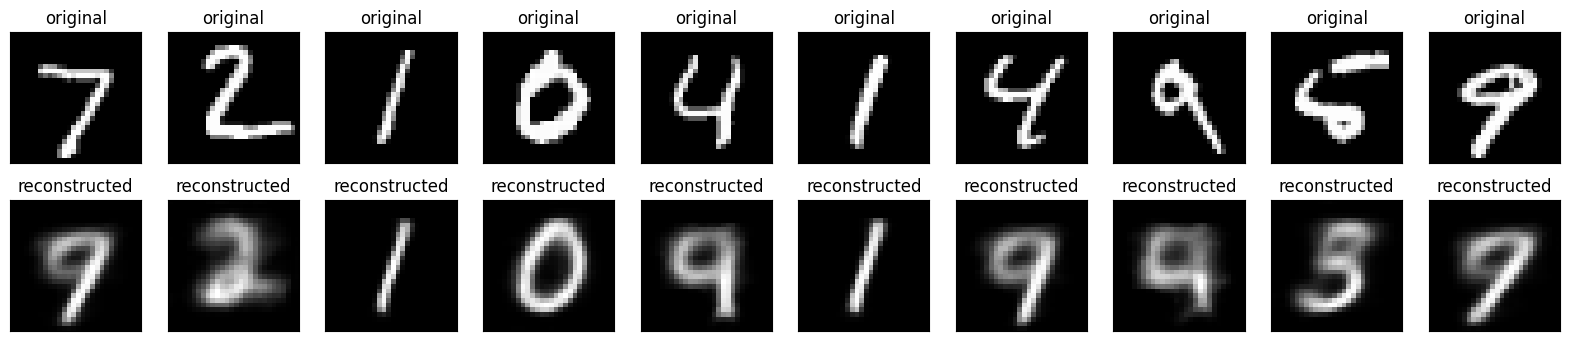

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Jeśli nie jesteś zadowolona/y z jakości wyników, możesz pobawić się siecią/hiperparametrami użytymi podczas treningu. W tym przypadku umieść informację o zastosowanych zmianach w raporcie.

Zaimplementuj funkcję do wizualizacji reprezentacji obrazów ze zbioru testowego w ukrytej przestrzeni 2-wymiarowej. Wyświetl wizualizację.

In [18]:
def plot_latent_space(model, data):
    z = model.encoder(data).numpy()
    plt.figure(figsize=(10, 10))
    plt.scatter(z[:, 0], z[:, 1], s=5, alpha=0.7)  
    plt.title("Latent Space")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()
    plt.show()

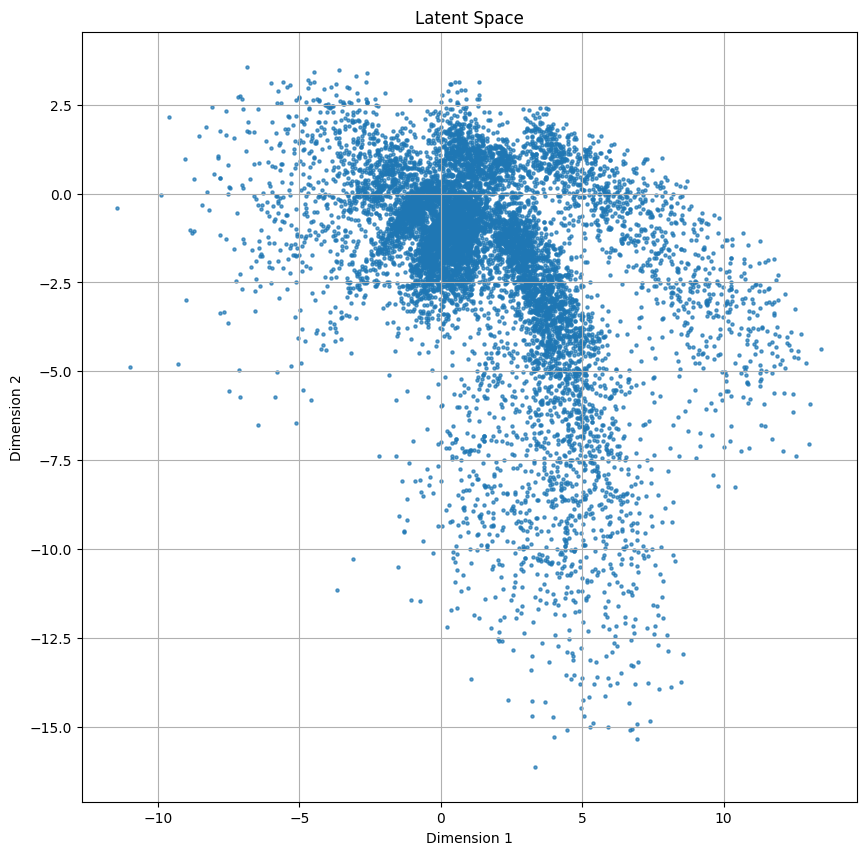

In [19]:
plot_latent_space(autoencoder, x_test)

Teraz wyświetlmy obrazy powstałe przez dekodowanie wartości z prostokątnej siatki. Dobierz granice siatki, analizując wyniki funkcji plot_latent_space.

In [20]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  grid_x = np.linspace(-2.5, 15, n)
  grid_y = np.linspace(-10, 10, n)
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.decoder(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

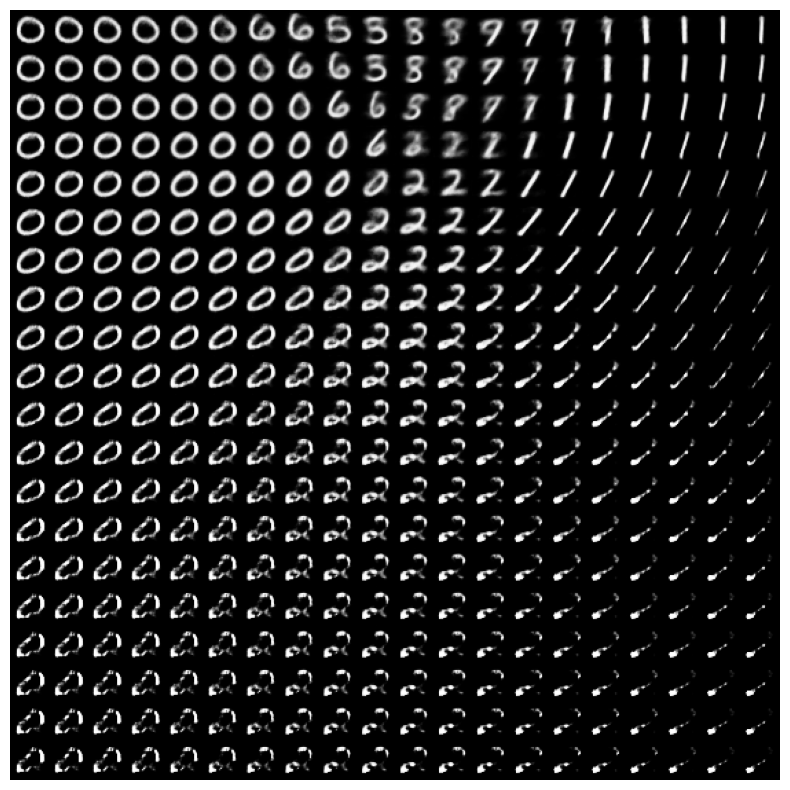

In [21]:
plot_latent_images(autoencoder, 20)

Zadanie 1.3. Wybierz ze zbioru testowego dwa obrazy z różnymi liczbami. Dobierz takie liczby, dla których spodziewasz się, że odkodowanie średniej z ich zenkodowanych reprezentacji będzie miało sens. Wybierz dwie takie pary.  
Dla każdej z par:  
* Wyświetl wybrane liczby.  
* Użyj enkodera do uzyskania 2-wymiarowych reprezentacji każdej liczby.  
* Wylicz średnią z tych reprezentacji.  
* Użyj dekodera na uzyskanej średniej.  
* Wyświetl wynik.
* Skomentuj wynik - czy przypomina jakąś liczbę? Czy takiego wyniku się spodziewałaś/eś?  

(0.25pkt)


Łączna liczba punktów do uzyskania za tę część: 0.75

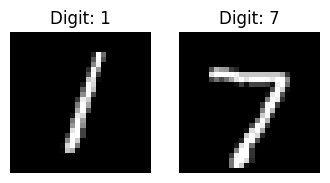

In [22]:
digit_1 = x_test[y_test == 1][0]  
digit_7 = x_test[y_test == 7][0]  

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(digit_1.squeeze(), cmap="gray")
plt.title("Digit: 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(digit_7.squeeze(), cmap="gray")
plt.title("Digit: 7")
plt.axis("off")

plt.show()

In [23]:
latent_1 = autoencoder.encoder(np.expand_dims(digit_1, axis=0)).numpy()
latent_7 = autoencoder.encoder(np.expand_dims(digit_7, axis=0)).numpy()

latent_mean = (latent_1 + latent_7) / 2

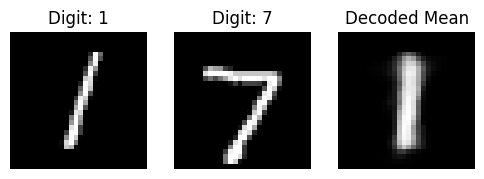

In [24]:
decoded_mean = autoencoder.decoder(latent_mean).numpy()

plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1)
plt.imshow(digit_1.squeeze(), cmap="gray")
plt.title("Digit: 1")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(digit_7.squeeze(), cmap="gray")
plt.title("Digit: 7")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(decoded_mean.squeeze(), cmap="gray")
plt.title("Decoded Mean")
plt.axis("off")

plt.show()

Dekodowany obraz przypomina cyfrę "1" z delikatnymi elementami poziomej kreski charakterystycznej dla "7". Wynik wygląda jak logiczne połączenie obu cyfr, choć jest lekko rozmyty.

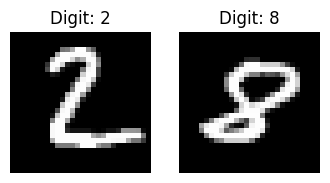

In [25]:
digit_2 = x_test[y_test == 2][0]  
digit_8 = x_test[y_test == 8][0]  

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(digit_2.squeeze(), cmap="gray")
plt.title("Digit: 2")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(digit_8.squeeze(), cmap="gray")
plt.title("Digit: 8")
plt.axis("off")

plt.show()

In [26]:
latent_2 = autoencoder.encoder(np.expand_dims(digit_2, axis=0)).numpy()
latent_8 = autoencoder.encoder(np.expand_dims(digit_8, axis=0)).numpy()

latent_mean = (latent_2 + latent_8) / 2

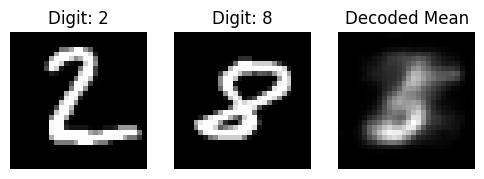

In [27]:
decoded_mean = autoencoder.decoder(latent_mean).numpy()

plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1)
plt.imshow(digit_2.squeeze(), cmap="gray")
plt.title("Digit: 2")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(digit_8.squeeze(), cmap="gray")
plt.title("Digit: 8")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(decoded_mean.squeeze(), cmap="gray")
plt.title("Decoded Mean")
plt.axis("off")

plt.show()

Dekodowany obraz przypomina cyfrę "3", która łączy górną krzywiznę "2" z dolnym okręgiem "8". Wynik jest sensowny, choć detale są mniej wyraźne.

# 2. AutoEnkoder wariacyjny (VAE)

Prosty AE nadaje się do różnych zadań, jak np. usuwanie szumu czy znajdowanie anomalii, ale nie jest najlepszą opcją do generowania obrazów z danego rozkładu (co widzieliśmy powyżej). W tej części zajmiemy się modelem znacznie lepiej nadającym się do tego zadania - autoenkoderem wariacyjnym.  
  
Zacznijmy od preprocessingu danych. Zwróć uwagę na reprezentację obrazów - tym razem będzie ona binarna - piksele będą mieć wartości 0/1. Będzie to miało wpływ na wybór funkcji kosztu! Moglibyśmy, oczywiście, dalej reprezentować obrazy jako wartości z całego zakresu [0; 1] i wtedy wykorzystać ten sam co wcześniej błąd rekonstrukcji, ale ponieważ takie podejście sprawdziliśmy wcześniej, tym razem zróbmy to inaczej.

In [28]:
def preprocess_images_vae(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

x_train = preprocess_images_vae(x_train_raw)
x_test = preprocess_images_vae(x_test_raw)

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_raw, test_size=0.15, random_state=42)

In [30]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
val_size = x_val.shape[0]

batch_size = 32

In [31]:
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
val_dataset = (tf.data.Dataset.from_tensor_slices(x_val)
               .shuffle(val_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

Zdefiniujmy model.  
Na co szczególnie warto zwrócić uwagę?  
* Enkoder: ostatnia warstwa to warstwa gęsta, z liczbą neuronów równą 2 * rozmiar przestrzeni ukrytej. Te neurony będą kodować wartości średniej oraz wariancji rozkładu normalnego, z którego próbki chcemy podawać na wejście dekodera podczas generacji obrazów. W praktyce zamiast wariancji neurony kodują wartości _logvar_ - czyli logarytmu z wariancji. Dzięki temu, że logarytm może przyjmować dowolne rzeczywiste wartości, unikamy konieczności optymalizacji wartości niezerowych.  
* Dekoder: zwróć uwagę na brak aktywacji w ostatniej warstwie dekodera, pomimo, że przecież generujemy obrazy z wartościami pikseli $\in$ {0, 1}. Jest to związane z preferowanym sposobem wyliczania funkcji kosztu, którą w tym wypadku jest cross-entropia. Zwróć uwagę na wywołanie funkcji _sigmoid_cross_entropy_with_logits_ z poziomu _compute_loss_. Moglibyśmy równie dobrze użyć aktywacji sigmoid, a następnie wyliczyć cross-entropię, ale podejście wykorzystujące _sigmoid_cross_entropy_with_logits_ jest bardziej stabilne numerycznie.

In [32]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

Zadanie 2.1. Dlaczego powyższa implementacje CVAE nie stosuje żadnej aktywacji w ostatniej warstwie enkodera? Czy jakaś funkcja by się tutaj nadawała? (0.25pkt)

Powyższa implementacja CVAE nie stosuje aktywacji w ostatniej warstwie enkodera, ponieważ generuje ona średnią i logarytm wariancji dla przestrzeni latentnej. Te wartości mogą przyjmować dowolne liczby rzeczywiste, co nie wymaga ograniczania ich zakresem, jak to robią funkcje aktywacji. Brak aktywacji pozwala modelowi swobodnie optymalizować parametry rozkładu normalnego. Żadna funkcja aktywacji nie jest tutaj konieczna ani odpowiednia, ponieważ mogłaby niepotrzebnie ograniczyć zakres wyników.

Zdefiniujmy dodatkowe funkcje: wyliczanie kosztu, wykonanie kroku treningu.  
Zwróć uwagę na funkcję kosztu. Składa się ona z trzech członów:  
$log P(X|z)$ - człon związany z odkodowanymi obrazami. Można go interpretować jako błąd rekonstrukcji.  
$logP(z)$ - człon związany z rozkładem, z którego losujemy elementy na wejście dekodera (prior).  
$logQ(z|X)$ - człon związany z aproksymowanym rozkładem $P(z|X)$ z pomocą prostszego rozkładu $Q(z|X)$ (posterior).

In [33]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Zdefiniujmy parametry treningu.

In [34]:
epochs = 10
latent_dim = 2
optimizer = tf.keras.optimizers.Adam(1e-4)

Po każdej epoce będziemy wizualizować generację obrazów powstałych przez podanie na wejściu dekodera reprezentacji powstałej z tych samych obrazów ze zbioru testowego. W ten sposób będziemy mogli obserwować poprawę jakości generacji w każdej epoce.

In [35]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [36]:
num_examples_to_generate = 16

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Zainicjalizujmy model i przeprowadźmy trening:

In [37]:
model = CVAE(latent_dim)

Epoch: 10, Val set ELBO: -158.09725952148438, time elapse for current epoch: 6.523681879043579


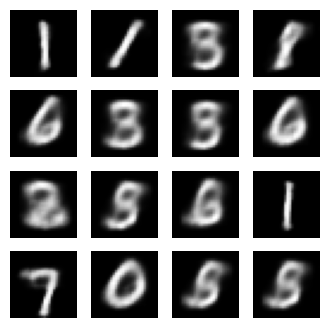

In [38]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x in val_dataset:
    loss(compute_loss(model, val_x))
  elbo = -loss.result()
  clear_output()
  print('Epoch: {}, Val set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

Z zapisanych podczas treningu obrazów możemy przygotować i wyświetlić gif:

In [39]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


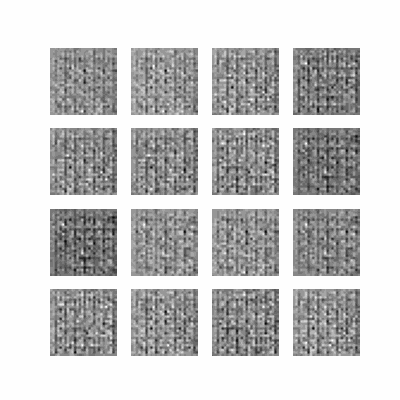

In [40]:
embed.embed_file(anim_file)

Narysujmy teraz, podobnie jak wcześniej dla AE, dwuwymiarową przestrzeń ukrytą. Zaimplementuj funkcję plot_latent_space, która zenkoduje zbiór danych, a następnie wyświetli każdy punkt wraz z odchyleniem standardowym.

In [41]:
def plot_latent_space(model, data):
    mean, logvar = model.encode(data)
    z = model.reparameterize(mean, logvar)
    stddev = tf.exp(logvar * 0.5)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(mean[:, 0], mean[:, 1], s=5, alpha=0.7, label="Latent Mean")
    plt.errorbar(mean[:, 0], mean[:, 1], xerr=stddev[:, 0], yerr=stddev[:, 1], fmt='o', alpha=0.3)
    plt.title("Latent Space with Standard Deviations")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid()
    plt.legend()
    plt.show()

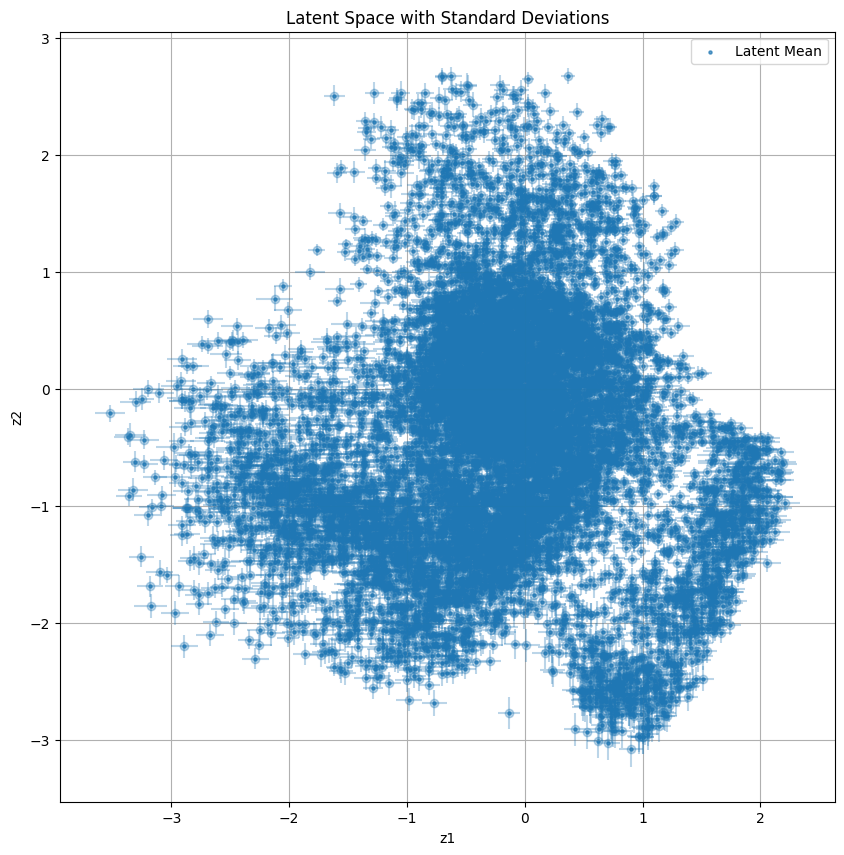

In [42]:
plot_latent_space(model, x_test)

Narysujmy również odkodowane obrazy, podając na wejście dekodera wartości z rozkładu normalnego:

In [43]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

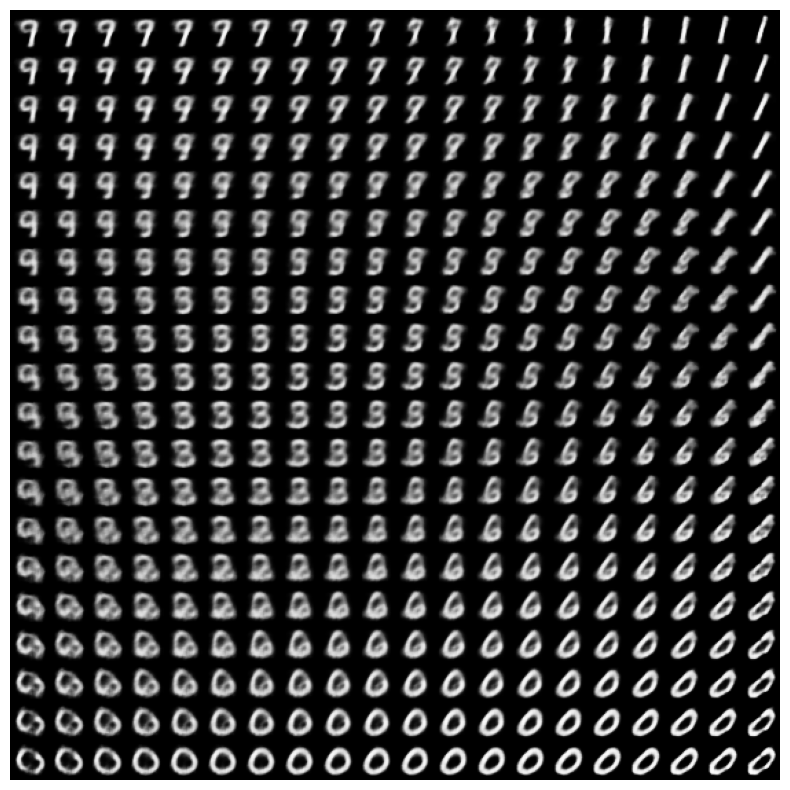

In [44]:
plot_latent_images(model, 20)

Zadanie 2.2. Skomentuj wynik uzyskany przy użyciu funkcji plot_latent_images. Zwróć uwagę na jakość/sensowność rysowanych liczb. Porównaj wykres do analogicznego wykresu dla modelu AE. Zamieść w raporcie wykresy. (0.25pkt)  

Obrazy wygenerowane przez VAE są bardziej spójne i mają logiczne przejścia między różnymi cyframi. Struktura cyfr pozostaje wyraźna, a przejścia między nimi są płynne, co wskazuje na dobrą organizację przestrzeni latentnej. Widoczna jest poprawna interpolacja – model wypełnia przestrzeń między cyframi sensownymi wartościami. Wynik jest zgodny z oczekiwaniami, biorąc pod uwagę, że VAE wymusza rozkład normalny w przestrzeni latentnej, co umożliwia generowanie bardziej realistycznych obrazów.

W przypadku AE wygenerowane obrazy są mniej spójne i czasem trudniejsze do zinterpretowania. Interpolacje między cyframi są mniej płynne, a przejścia nie zawsze mają sens. Niektóre cyfry są rozmazane lub zdeformowane, co wskazuje na chaotyczną organizację przestrzeni latentnej. Model AE nie wymusza żadnego rozkładu w przestrzeni latentnej, co skutkuje gorszym odwzorowaniem cyfr.

Zadanie 2.3. Porównaj wyniki funkcji _plot_latent_space_ dla AE oraz VAE. Zwróć uwagę na "gęstość" punktów oraz zakres wartości. Zamieść w raporcie wykresy. (0.25pkt)   

Porównując wyniki funkcji plot_latent_space,  AE i VAE różnią się organizacją przestrzeni latentnej. W AE punkty są chaotycznie rozproszone w szerokim zakresie wartości, co utrudnia interpolację i generowanie spójnych danych. Z kolei w VAE punkty są równomiernie rozmieszczone i skoncentrowane w zakresie od -3 do 3, dzięki  czemu przestrzeń latentna jest uporządkowana, a generowane wyniki bardziej stabilne i sensowne. Regularyzacja KL-divergence w w VAE pozwala na lepsze odwzorowanie rozkładu normalnego, co znacząco poprawia jakość modelu w porównaniu do AE.

Zadanie 2.4. Dla tych samych par obrazów, na których pracowałaś/eś w ostatnim zadaniu dot. AE, przygotuj reprezentacje ukryte z pomocą wytrenowanego VAE i odkoduj średnie z reprezentacji. Skomentuj wyniki, porównaj z wynikami z AE. (0.25pkt)  

In [45]:
digit_1 = x_test[y_test == 1][0]  
digit_7 = x_test[y_test == 7][0]  

In [46]:
mean_1, logvar_1 = model.encode(np.expand_dims(digit_1, axis=0))
mean_7, logvar_7 = model.encode(np.expand_dims(digit_7, axis=0))\

latent_mean = (mean_1 + mean_7) / 2

In [47]:
decoded_image = model.decode(latent_mean).numpy()

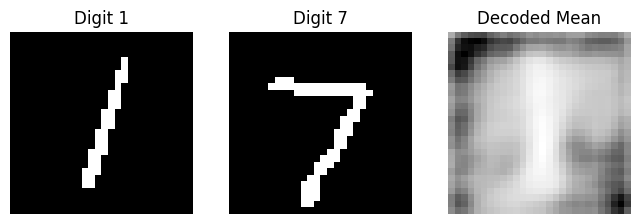

In [48]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(digit_1.squeeze(), cmap='gray')
plt.title("Digit 1")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(digit_7.squeeze(), cmap='gray')
plt.title("Digit 7")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(decoded_image.squeeze(), cmap='gray')
plt.title("Decoded Mean")
plt.axis("off")
plt.show()

In [49]:
digit_2 = x_test[y_test == 2][0]  
digit_8 = x_test[y_test == 8][0] 

In [50]:
mean_2, logvar_2 = model.encode(np.expand_dims(digit_2, axis=0))
mean_8, logvar_8 = model.encode(np.expand_dims(digit_8, axis=0))

latent_mean = (mean_2 + mean_8) / 2

In [51]:
decoded_image = model.decode(latent_mean).numpy()

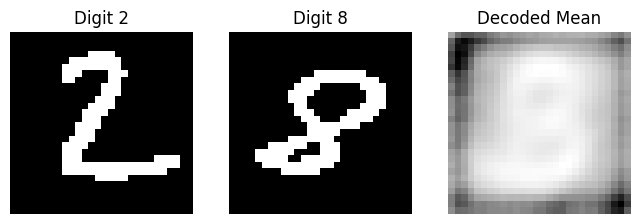

In [52]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(digit_2.squeeze(), cmap='gray')
plt.title("Digit 2")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(digit_8.squeeze(), cmap='gray')
plt.title("Digit 8")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(decoded_image.squeeze(), cmap='gray')
plt.title("Decoded Mean")
plt.axis("off")
plt.show()

Porównując wyniki VAE i AE, zauważalne są różnice w jakości i charakterystyce dekodowanych obrazów. W przypadku VAE obrazy są bardziej rozmyte, co wynika z regularyzacji KL-divergence wymuszającej uśrednianie cech i dopasowanie do rozkładu normalnego w przestrzeni latentnej. Jednak mimo większego rozmycia, obrazy generowane przez VAE zachowują logiczne cechy obu cyfr, co widać w przypadku par "1" i "7" oraz "2" i "8". Dla AE obrazy są bardziej wyraziste, ale mniej spójne – dekodowane średnie często przypominają jedną cyfrę bardziej niż hybrydę obu.

Podsumowując, VAE generuje bardziej sensowne interpolacje kosztem wyrazistości obrazów, podczas gdy AE dostarcza bardziej szczegółowe, ale mniej logiczne wyniki.

Zadanie 2.5. Wróć do funkcji _compute_loss_. Człony _logpz_ oraz _logqz\_x_ związane są z obliczaniem KL-divergence pomiędzy $Q(z|X)$ oraz $P(z)$. Zakładamy, że oba te rozkłady są gaussowskie, stąd możemy wykorzystać wzór na KL-divergence dla dwóch rozkładów gaussowskich. Znajdź ten wzór oraz przepisz funkcję _compute_loss_ z jego wykorzystaniem. Zamieść w raporcie przygotowaną formułę. Wytrenuj model ponownie, porównaj wyniki z poprzednią implementacją _compute_loss_. (0.25pkt)


UWAGA: jeśli na którymkolwiek etapie nie jesteś zadowolona/y z działania modelu, możesz dokonać jego modyfikacji (podobnie jak dla AE).

Łączna liczba punktów do uzyskania za tę część: 1.25

In [53]:
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

    kl_divergence = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)

    return -tf.reduce_mean(logpx_z - kl_divergence)

In [54]:
latent_dim = 2
model = CVAE(latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    loss = tf.keras.metrics.Mean()
    for val_x in val_dataset:
        loss(compute_loss(model, val_x))
    elbo = -loss.result()
    end_time = time.time()
    
    print('Epoch: {}, Val set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch+1, elbo, end_time - start_time))

Epoch: 1, Val set ELBO: -182.34532165527344, time elapse for current epoch: 11.93561053276062
Epoch: 2, Val set ELBO: -172.8545684814453, time elapse for current epoch: 9.769741773605347
Epoch: 3, Val set ELBO: -168.69493103027344, time elapse for current epoch: 9.976976871490479
Epoch: 4, Val set ELBO: -165.65016174316406, time elapse for current epoch: 9.840113878250122
Epoch: 5, Val set ELBO: -163.71463012695312, time elapse for current epoch: 9.752809286117554
Epoch: 6, Val set ELBO: -162.13357543945312, time elapse for current epoch: 10.009195327758789
Epoch: 7, Val set ELBO: -160.6450653076172, time elapse for current epoch: 9.713056564331055
Epoch: 8, Val set ELBO: -159.58921813964844, time elapse for current epoch: 9.800577640533447
Epoch: 9, Val set ELBO: -158.75161743164062, time elapse for current epoch: 10.044653415679932
Epoch: 10, Val set ELBO: -158.4520721435547, time elapse for current epoch: 9.789798021316528


Porównując wyniki, nowa implementacja funkcji compute_loss z dokładnym wzorem na KL-divergence osiągnęła lepsze ELBO, co wskazuje na poprawę jakości modelu. Oznacza to, że model zaktualizowany o bardziej precyzyjne obliczenia lepiej dopasowuje rozkład latentny do danych. Czas trenowania dla każdej epoki wzrósł, co wynika z bardziej złożonych obliczeń KL-divergence. Jednak wzrost jakości modelu uzasadnia wydłużenie czasu treningu.

Ogólnie rzecz biorąc, nowa wersja funkcji compute_loss poprawiła zarówno ELBO, jak i sensowność generowanych danych, przy nieznacznie wyższym koszcie czasowym.

# 3. Conditioned VAE

W tej części rozszerzymy model VAE poprzez dodanie do modelu informacji o generowanym obrazie. Przygotujemy nowy zbiór danych, bazujący na MNIST, który będzie zawierał cyfry w różnych miejscach. Będziemy rozważać 9 pozycji, rozmieszczonych na siatce 3x3. Dodatkową informacją będzie 12-elementowy wektor, zawierający: etykietę (one-hot), położenie x, położenie y cyfry.  

Zacznijmy od przygotowania zbioru danych. Będziemy generować obrazy w rozmiarze (42, 42), a bazowe cyfry będą mieć rozmiar (14, 14).

In [55]:
x_train_small = tf.image.resize(x_train, (14, 14)).numpy()
x_val_small = tf.image.resize(x_val, (14, 14)).numpy()
x_test_small = tf.image.resize(x_test, (14, 14)).numpy()

In [56]:
encoder = OneHotEncoder()

In [57]:
y_train = encoder.fit_transform(y_train.reshape((-1, 1))).toarray()
y_val = encoder.transform(y_val.reshape((-1, 1))).toarray()
y_test = encoder.transform(y_test.reshape((-1, 1))).toarray()

In [58]:
x_train_small.shape, y_train.shape

((51000, 14, 14, 1), (51000, 10))

Uzupełnij funkcję, która z każdego obrazu ze zbioru danych x tworzy 9 obrazów z cyfrą na każdej z 9 pozycji siatki 3x3, a także tworzy etykiety y w postaci wektora [cyfra-one-hot, pozycja_x, pozycja_y]. Dla każdej pary z oryginalnego zbioru danych (obraz, etykieta) wylosuj num_imgs par, które znajdą się w docelowym zbiorze danych (nie zapisujemy wszystkich 9 możliwości ze względu na ograniczenia RAM).

In [59]:
def conditioned_mnist(x, y, num_imgs=2):
  x_res = np.empty(shape=(x.shape[0] * num_imgs, x.shape[1] * 3, x.shape[2] * 3), dtype='float32')  # pusta macierz z wynikami - obrazy x
  y_res = np.empty(shape=(x.shape[0] * num_imgs, 12), dtype='float32')   # pusta macierz z wynikami - wektor y: etykieta (10 liczb), pozycja x, pozycja y
  empty_res = np.zeros(shape=(x.shape[1] * 3, x.shape[2] * 3))  # obraz wynikowy w docelowym rozmiarze, wypełniony zerami

  for el, (arr, label) in enumerate(zip(x, y)):
    to_sample_x = np.empty((9, x.shape[1]*3, x.shape[2]*3), dtype='float32')  # macierz przechowująca 9 wersji obrazu
    to_sample_y = np.empty((9, 12), dtype='float32')  # macierz przechowująca 9 wersji etykiet
    for i in range(3):
      for j in range(3):
        curr_x = empty_res.copy()
        curr_x[i*x.shape[1]: (i+1)*x.shape[1], j*x.shape[2]: (j+1)*x.shape[2]] = arr.reshape((x.shape[1], x.shape[2]))
        curr_y = [*label, i/2, j/2]  # normalizacja
        to_sample_x[3*i+j] = curr_x
        to_sample_y[3*i+j] = curr_y
    idxs = np.random.choice(9, num_imgs, replace=False)  # wylosuj num_imgs indeksów z zakresu [0; 8] jako wektor numpy
    x_res[el * num_imgs: (el + 1) * num_imgs] = to_sample_x[idxs]
    y_res[el * num_imgs: (el + 1) * num_imgs] = to_sample_y[idxs]
  x_res = x_res.reshape((-1, x.shape[1]*3, x.shape[2]*3, 1))
  return x_res, y_res


Przygotujmy zbiór danych, zawierający po 2 wersje dla każdego obrazu:

In [60]:
num_imgs = 2

In [61]:
x_train_cond, y_train_cond = conditioned_mnist(x_train_small, y_train, num_imgs)

In [62]:
x_train_cond.shape, y_train_cond.shape

((102000, 42, 42, 1), (102000, 12))

In [63]:
x_val_cond, y_val_cond = conditioned_mnist(x_val_small, y_val)
x_test_cond, y_test_cond = conditioned_mnist(x_test_small, y_test)

Uzupełnij klasę Cond_CVAE na podstawie klasy CVAE. W tym celu:  
1. Uzupełnij funkcję prepare_encoder. Będziemy mieć dwa wejścia do modelu - jedno na obraz, jedno na wektor cech [etykieta, pos_x, pos_y]. Przeprocesuj obraz z pomocą warstw konwolucyjnych (możesz wykorzystać implementację z CVAE). Możesz też przygotować kilka warstw, które zajmą się wektorem cech. Użyj warstwy konkatenującej wyniki z przetwarzania obrazu i wektora cech. Za tą warstwą znajdzie się warstwa gęsta, wyliczająca średnią i logvar.  
  
2. Uzupełnij funkcję prepare_decoder. Tu również mamy do czynienia z dwoma wejściami - jedno przyjmuje szum, drugie wektor cech. Połącz oba wejścia i przygotuj dekoder. Możesz skorzystać z implementacji CVAE, ale będą potrzebne zmiany związane z innym rozmiarem obrazów.

Pozostałe funkcje są już zaimplementowane. Przyjrzyj się im. Co się zmieniło względem implementacji CVAE?


In [64]:
class Cond_CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(Cond_CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = self.prepare_encoder()
    self.decoder = self.prepare_decoder()

  def prepare_encoder(self):
    input_img = tf.keras.layers.Input(shape=(42, 42, 1))
    input_cond = tf.keras.layers.Input(shape=(12,))

    x_img = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(input_img)
    x_img = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x_img)
    x_img = tf.keras.layers.Flatten()(x_img)

    x_cond = tf.keras.layers.Dense(64, activation='relu')(input_cond)
    x_cond = tf.keras.layers.Dense(32, activation='relu')(x_cond)

    x = tf.keras.layers.Concatenate()([x_img, x_cond])
    x = tf.keras.layers.Dense(self.latent_dim + self.latent_dim)(x)
        
    return tf.keras.Model([input_img, input_cond], x)
        
  def prepare_decoder(self):
    input_latent = tf.keras.layers.Input(shape=(self.latent_dim,))
    input_cond = tf.keras.layers.Input(shape=(12,))
    inputs = tf.keras.layers.Concatenate()([input_latent, input_cond])
    x = tf.keras.layers.Dense(units=7 * 7 * 64, activation='relu')(inputs)
    x = tf.keras.layers.Reshape(target_shape=(7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=2, padding='same', activation='relu'
    )(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=2, padding='same', activation='relu'
    )(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=1, padding='same'
    )(x)
    x = tf.keras.layers.Resizing(42, 42)(x)  
    return tf.keras.Model([input_latent, input_cond], x)


  @tf.function
  def sample(self, cond, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode([eps, cond], apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, inputs, apply_sigmoid=False):
    logits = self.decoder(inputs)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

W porównaniu do klasycznego CVAE, Cond_CVAE wprowadza dodatkowe wejście w enkoderze i dekoderze, które pozwala uwzględnić wektor cech składający się z etykiety (one-hot) oraz współrzędnych pozycji cyfry (x, y). Enkoder przetwarza obraz za pomocą warstw konwolucyjnych oraz wektor cech przez warstwy gęste, a następnie łączy te informacje, aby wyliczyć średnią i log-wariancję. W dekoderze, połączenie wektora latentnego i cech umożliwia generowanie obrazów warunkowanych na dodatkowych informacjach.

Zmodyfikowano także rozmiar generowanych obrazów z 28x28 na 42x42, co wymagało dostosowania warstw transponowanych konwolucji w dekoderze. Dzięki temu model potrafi generować obrazy z cyframi na różnych pozycjach siatki 3x3, warunkując wynik na zadanych cechach. Wprowadzone zmiany sprawiają, że Cond_CVAE jest bardziej elastyczne i funkcjonalne, pozwalając na generowanie obrazów o wyraźnie określonych cechach, podczas gdy CVAE operowało jedynie na obrazach bez dodatkowego kontekstu.

Przygotowanie do treningu:

In [65]:
epochs = 10
batch_size = 32

In [66]:
num_examples_to_generate = 16

Nie będziemy tym razem wizualizować przestrzeni ukrytej, ale zacznijmy od latent_dim=2.

In [67]:
latent_dim = 2
model = Cond_CVAE(latent_dim)

In [68]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_cond).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(x_val_cond).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test_cond).batch(batch_size)

train_dataset_cond = tf.data.Dataset.from_tensor_slices(y_train_cond).batch(batch_size)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_val_cond).batch(batch_size)
test_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test_cond).batch(batch_size)

train_dataset_with_cond = tf.data.Dataset.zip((train_dataset, train_dataset_cond)).shuffle(train_size*num_imgs)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset, val_dataset_cond)).shuffle(val_size*num_imgs)
test_dataset_with_cond = tf.data.Dataset.zip((test_dataset, test_dataset_cond)).shuffle(test_size*num_imgs)

In [69]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset_with_cond.take(1):
  test_sample_data = test_batch[0][0:num_examples_to_generate, :, :, :]
  test_sample_cond = test_batch[1][0:num_examples_to_generate, :]
test_sample = [test_sample_data, test_sample_cond]

Uzupełnij funkcję kosztu:

In [70]:
def compute_loss(model, x):
  data, cond = x
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode([z, cond])
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=data)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

Ostatnie definicje/inicjalizacje:

In [71]:
def generate_and_save_images(model, epoch, test_sample):
  data, cond = test_sample
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(cond, z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [72]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [73]:
optimizer = tf.keras.optimizers.Adam(1e-4)

...i zaczynamy trening.

Epoch: 10, Val set ELBO: -40.27174377441406, time elapse for current epoch: 16.647506952285767


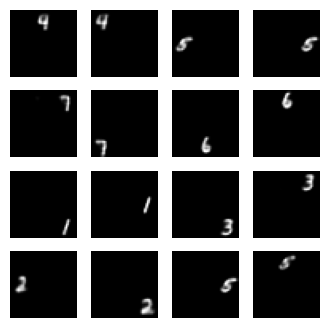

In [74]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset_with_cond:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x in val_dataset_with_cond:
    loss(compute_loss(model, val_x))
  elbo = -loss.result()
  clear_output()
  print('Epoch: {}, Val set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [75]:
anim_file = 'cond_cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


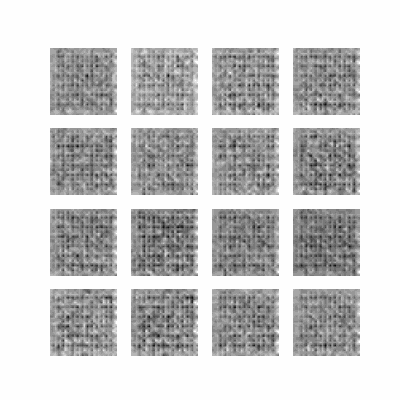

In [76]:
embed.embed_file(anim_file)

Jeśli model zupełnie nie radzi sobie z zadaniem, pobaw się definicją modelu bądź hiperparametrami (głównie batch_size, liczba epok). Model powinien zwracać rozsądne wyniki zarówno w konktekście położenia, jak i rodzaju generowanej cyfry.

Zadanie 3.1. Sprawdź jakość modelu dla 3 różnych wartości latent_dim (trzeba dla każdej z nich osobno wytrenować model). Niech będą od siebie znacząco różne, np. 2, 25, 100. Przy większym latent_dim może być potrzebnych więcej epok.  
Punktacja:  
Skuteczny trening dla jednej wartości latent dim = 1 pkt.  
0.5 pkt za testy dla dwóch innych wartości latent_dim (po 0.25 za każdą). Punkty będą przyznane, jeśli model będzie w stanie generować _sensowne_ wyniki.  

In [77]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [78]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Epoch: 10, Val set ELBO: -40.399959564208984, time elapse for current epoch: 16.19


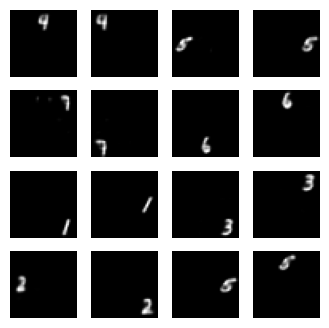

In [79]:
latent_dim = 2
epochs = 10
results = {}

print(f"Training model with latent_dim = {latent_dim}")

tf.keras.backend.clear_session()

model = Cond_CVAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset_with_cond:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for val_x in val_dataset_with_cond:
        loss(compute_loss(model, val_x))
    elbo = -loss.result()
    clear_output()
    print(f"Epoch: {epoch}, Val set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time:.2f}")

    generate_and_save_images(model, epoch, test_sample)

results[latent_dim] = elbo.numpy()


In [80]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [81]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Epoch: 10, Val set ELBO: -41.34621047973633, time elapse for current epoch: 16.24


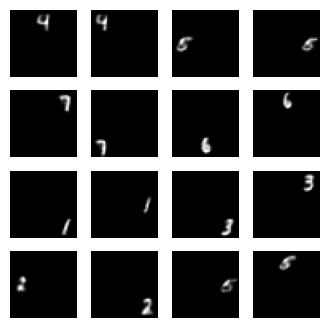

In [82]:
latent_dim = 25
epochs = 10
results = {}

print(f"Training model with latent_dim = {latent_dim}")

tf.keras.backend.clear_session()

model = Cond_CVAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset_with_cond:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for val_x in val_dataset_with_cond:
        loss(compute_loss(model, val_x))
    elbo = -loss.result()
    clear_output()
    print(f"Epoch: {epoch}, Val set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time:.2f}")

    generate_and_save_images(model, epoch, test_sample)

results[latent_dim] = elbo.numpy()


In [83]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [84]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Epoch: 10, Val set ELBO: -43.64799880981445, time elapse for current epoch: 16.27


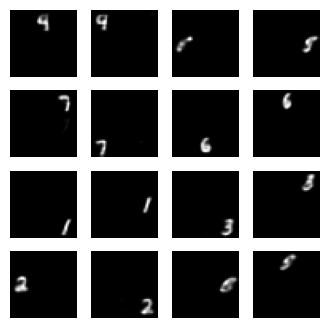

In [85]:
latent_dim = 100
epochs = 10
results = {}

print(f"Training model with latent_dim = {latent_dim}")

tf.keras.backend.clear_session()

model = Cond_CVAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset_with_cond:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for val_x in val_dataset_with_cond:
        loss(compute_loss(model, val_x))
    elbo = -loss.result()
    clear_output()
    print(f"Epoch: {epoch}, Val set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time:.2f}")

    generate_and_save_images(model, epoch, test_sample)

results[latent_dim] = elbo.numpy()

Testy dla różnych wartości latent_dim (2, 25, 100) pokazują, że latent_dim = 2 daje najbardziej wyraźne obrazy, co wskazuje na efektywne wykorzystanie ograniczonej przestrzeni reprezentacyjnej (ELBO = -40). Dla latent_dim = 25 obrazy są nadal sensowne, ale nieco bardziej rozmyte, co może wynikać z większej złożoności modelu (ELBO = -41). Natomiast dla latent_dim = 100 obrazy są znacznie mniej wyraźne i rozmyte, co prawdopodobnie wynika z nadmiaru niewykorzystanej przestrzeni latentnej (ELBO = -43). Latent_dim = 2 okazuje się najlepszym wyborem pod względem jakości generowanych obrazów.

  
Zadanie 3.2. Wykonaj dla najlepszego modelu z punktu 3.1.:
* Wybierz przykład ze zbioru testowego (obraz + etykieta).  
* Przepuść próbkę przez enkoder, uzyskaj reprezentację _z_.  
* Dla każdego z 9 możliwych wektorów [poprawna_etykieta, pos_x, pos_y] przepuść przez dekoder reprezentację _z_ wraz z informacją o etykiecie i położeniu. Wyświetl uzyskany obraz. Skomentuj wyniki - czy za każdym razem uzyskano oczekiwaną liczbę w oczekiwanym miejscu? Jeśli nie, to co może być przyczyną? (0.25 pkt)  


In [110]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [111]:
latent_dim = 2
epochs = 10 

print(f"Training model with latent_dim = {latent_dim}")
tf.keras.backend.clear_session()

model = Cond_CVAE(latent_dim) 
optimizer = tf.keras.optimizers.Adam(1e-4)

Training model with latent_dim = 2


In [112]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset_with_cond:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for val_x in val_dataset_with_cond:
        loss(compute_loss(model, val_x))
    elbo = -loss.result()
    
    print(f"Epoch: {epoch}, Val set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time:.2f}")

Epoch: 1, Val set ELBO: -50.29544448852539, time elapse for current epoch: 19.29
Epoch: 2, Val set ELBO: -46.14002990722656, time elapse for current epoch: 16.47
Epoch: 3, Val set ELBO: -43.925655364990234, time elapse for current epoch: 16.51
Epoch: 4, Val set ELBO: -42.88264846801758, time elapse for current epoch: 16.41
Epoch: 5, Val set ELBO: -42.142189025878906, time elapse for current epoch: 16.67
Epoch: 6, Val set ELBO: -41.575103759765625, time elapse for current epoch: 16.62
Epoch: 7, Val set ELBO: -41.159942626953125, time elapse for current epoch: 16.52
Epoch: 8, Val set ELBO: -40.787437438964844, time elapse for current epoch: 16.56
Epoch: 9, Val set ELBO: -40.51938247680664, time elapse for current epoch: 16.21
Epoch: 10, Val set ELBO: -40.32427978515625, time elapse for current epoch: 16.26


In [113]:
test_example = next(iter(test_dataset_with_cond))
test_image, test_label = test_example

test_data, test_cond = test_image[0:1], test_label[0:1]

In [114]:
mean, logvar = model.encode([test_data, test_cond])
z = model.reparameterize(mean, logvar)

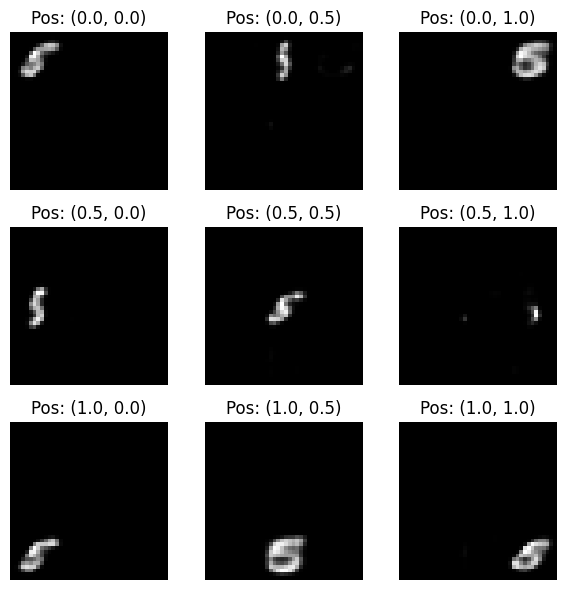

In [115]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
positions = [(i / 2, j / 2) for i in range(3) for j in range(3)]

for idx, (pos_x, pos_y) in enumerate(positions):
    cond = test_cond.numpy()
    cond[0, -2] = pos_x 
    cond[0, -1] = pos_y  
    
    cond = tf.convert_to_tensor(cond, dtype=tf.float32)
    
    generated_image = model.decode([z, cond])
    generated_image = tf.sigmoid(generated_image).numpy()[0, :, :, 0]  

    ax = axs[idx // 3, idx % 3]
    ax.imshow(generated_image, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Pos: ({pos_x:.1f}, {pos_y:.1f})")

plt.tight_layout()
plt.show()


Dla każdego z 9 możliwych wektorów [poprawna_etykieta, pos_x, pos_y], model generuje obrazy, które generalnie odzwierciedlają oczekiwaną cyfrę "5" w różnych pozycjach siatki 3x3. W większości przypadków cyfry są poprawnie zlokalizowane, co wskazuje na skuteczne uwzględnienie informacji o pozycji w procesie dekodowania. Jednak niektóre obrazy są rozmyte, co może wynikać z ograniczeń modelu w precyzyjnym odwzorowaniu pozycji lub reprezentacji latentnej. Sądzę, że model działa poprawnie, ale może wymagać dalszego dostrojenia, aby poprawić jakość i dokładność generowanych obrazów.

Zadanie 3.3. Powtórz zadanie 3.2, ale tym razem jako reprezentację _z_ wykorzystaj wartości wylosowane z rozkładu normalnego oraz wybierz dowolną etykietę. Skomentuj wyniki - czy za każdym razem uzyskano oczekiwaną liczbę w oczekiwanym miejscu? (0.25 pkt)

Za tę część: 2 punkty

In [120]:
z_random = tf.random.normal(shape=(1, model.latent_dim))

random_label = tf.one_hot([5], depth=10)  
random_label = tf.tile(random_label, [1, 1])  

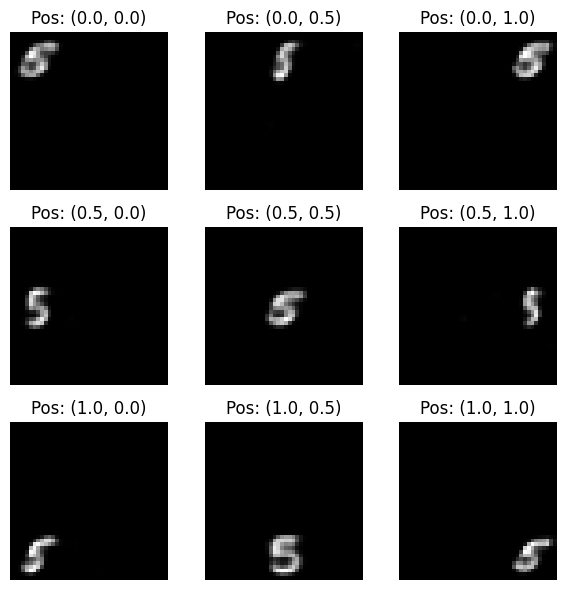

In [121]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
positions = [(i / 2, j / 2) for i in range(3) for j in range(3)] 

for idx, (pos_x, pos_y) in enumerate(positions):
    cond = np.zeros((1, 12))
    cond[0, :10] = random_label.numpy()
    cond[0, -2] = pos_x  
    cond[0, -1] = pos_y  
    
    cond = tf.convert_to_tensor(cond, dtype=tf.float32)
    
    generated_image = model.decode([z_random, cond])
    generated_image = tf.sigmoid(generated_image).numpy()[0, :, :, 0] 
    
    ax = axs[idx // 3, idx % 3]
    ax.imshow(generated_image, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Pos: ({pos_x:.1f}, {pos_y:.1f})")

plt.tight_layout()
plt.show()

Model w większości przypadków poprawnie wygenerował cyfrę "5" w oczekiwanych miejscach na siatce. Niewielkie rozmycia mogą być spowodowane interakcją losowej reprezentacji z z warunkami wejściowymi, co jest naturalne w tego typu modelach. Ogólnie wynik można uznać za satysfakcjonujący.

# 4. Conditioned GAN

W ostatniej części wytrenujemy sieć GAN na obrazach ze zbioru MNIST. Ponownie przygotujemy implementację z dodatkowym wektorem wejściowym - tym razem będzie to wektor jednoelementowy z etykietą.

Wracamy do ciągłej reprezentacji obrazów:

In [122]:
def preprocess_images_gan(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return images.astype('float32')

x_train = preprocess_images_gan(x_train_raw)
y_train = encoder.transform(y_train_raw.reshape((-1, 1))).toarray()

In [123]:
y_train.shape

(60000, 10)

In [124]:
train_size = x_train.shape[0]

batch_size = 256

Przygotujmy dataset. Będzie on zawierał:
* Obrazy.
* Dodatkowe wektory wejściowe z etykietami.
* Wektory wejściowe z etykietami do generowania przykładów przez generator w trakcie treningu.

In [125]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
train_dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size)
train_dataset_fake_cond = tf.data.Dataset.from_tensor_slices(y_train).shuffle(train_size).batch(batch_size)

train_dataset_with_cond = tf.data.Dataset.zip((train_dataset, train_dataset_cond, train_dataset_fake_cond)).shuffle(train_size)

Uzupełnij definicję generatora:

In [129]:
def prepare_generator(latent_dim, cond_dim):
  input_img = tf.keras.layers.Input(shape=(latent_dim,))
  input_cond = tf.keras.layers.Input(shape=(cond_dim,))
  inputs = tf.keras.layers.Concatenate(axis=1)([input_img, input_cond])

  x1 = tf.keras.layers.Dense(7*7*256, use_bias=False)(inputs)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.LeakyReLU()(x1)
  x1 = tf.keras.layers.Reshape((7, 7, 256))(x1)

  x1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.LeakyReLU()(x1)

  x1 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.LeakyReLU()(x1)

  x1 = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x1)

  return tf.keras.Model([input_img, input_cond], x1, name='generator')

In [150]:
# Wersja poprawiona
def prepare_generator_1(latent_dim, cond_dim):
    input_img = tf.keras.layers.Input(shape=(latent_dim,))
    input_cond = tf.keras.layers.Input(shape=(cond_dim,))
    inputs = tf.keras.layers.Concatenate(axis=1)([input_img, input_cond])

    x = tf.keras.layers.Dense(7 * 7 * 512, use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((7, 7, 512))(x)

    x = tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    output = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model([input_img, input_cond], output, name='generator')


In [151]:
latent_dim = 100
cond_dim = 10

Wyświetlmy obraz wygenerowany przez niewytrenowany generator przy podaniu na wejściu etykiety "1":

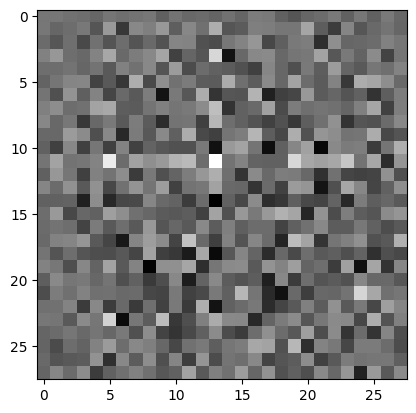

In [131]:
generator = prepare_generator(latent_dim, cond_dim)

noise = tf.random.normal([1, latent_dim])
label = tf.constant(np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1, -1))
generated_image = generator([noise, label], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

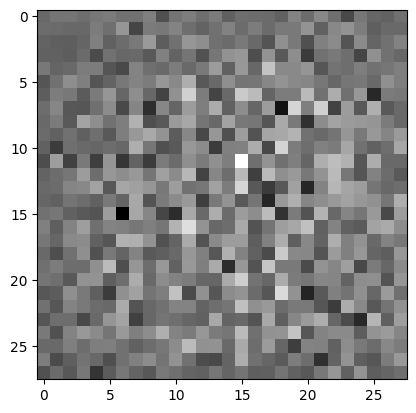

In [152]:
generator = prepare_generator_1(latent_dim, cond_dim)

noise = tf.random.normal([1, latent_dim])
label = tf.constant(np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1, -1))
generated_image = generator([noise, label], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Uzupełnij definicję dyskryminatora:

In [132]:
def prepare_discriminator(img_shape, cond_dim):
  input_img = tf.keras.layers.Input(shape=img_shape)
  x = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_img)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)

  x = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)

  x = tf.keras.layers.Flatten()(x)

  input_cond = tf.keras.layers.Input(shape=(cond_dim,))

  x = tf.keras.layers.Concatenate(axis=1)([x, input_cond])

  x = tf.keras.layers.Dense(256)(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)

  x = tf.keras.layers.Dense(1)(x)
    
  return tf.keras.Model([input_img, input_cond], x, name='discriminator')


In [153]:
#Wersja poprawiona
def prepare_discriminator_1(img_shape, cond_dim):
    input_img = tf.keras.layers.Input(shape=img_shape)
    input_cond = tf.keras.layers.Input(shape=(cond_dim,))

    x = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(input_img)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Concatenate(axis=1)([x, input_cond])
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1)(x)

    return tf.keras.Model([input_img, input_cond], output, name='discriminator')

In [133]:
img_shape = (28, 28, 1)

Zobaczmy predykcję niewytrenowanego dyskryminatora:

In [134]:
discriminator = prepare_discriminator(img_shape, cond_dim)
decision = discriminator([generated_image, label])
print(decision)

tf.Tensor([[-0.02252227]], shape=(1, 1), dtype=float32)


In [154]:
discriminator = prepare_discriminator_1(img_shape, cond_dim)
decision = discriminator([generated_image, label])
print(decision)

tf.Tensor([[-0.00815951]], shape=(1, 1), dtype=float32)


In [155]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Uzupełnij funkcje kosztu:

In [156]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [157]:
def generator_loss(fake_output):
    # fake_output - predykcja dyskryminatora
     return cross_entropy(tf.ones_like(fake_output), fake_output)

Inicjalizacje:

In [158]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [159]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = tf.one_hot(tf.random.uniform(shape=[num_examples_to_generate], minval=0, maxval=10, dtype=tf.int32), depth=10)

Uzupełnij funkcję train_step:

In [160]:
@tf.function
def train_step(data):
    images, cond, noise_cond = data
    batch_size = tf.shape(images)[0]

    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, noise_cond], training=True)
        real_output = discriminator([images, cond], training=True)
        fake_output = discriminator([generated_images, noise_cond], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Czas na trening!

In [161]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [162]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    clear_output()
    generate_and_save_images(generator,
                             epoch + 1,
                             [seed, seed_cond])

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  clear_output()
  generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])

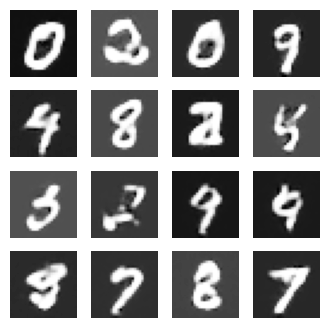

In [144]:
train(train_dataset_with_cond, EPOCHS)

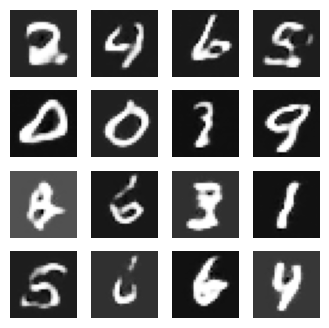

In [163]:
#Wersja poprawiona
train(train_dataset_with_cond, EPOCHS)

In [145]:
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


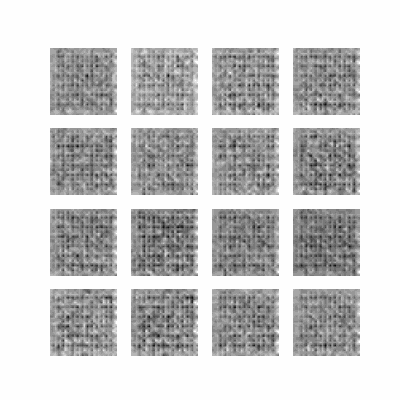

In [146]:
embed.embed_file(anim_file)

Zadanie 4.1. Wygeneruj po jednym obrazie z każdą liczbą z pomocą generatora. Oceń jakość wyników. Jeśli jakość modelu pozostawia wiele do życzenia, spróbuj go poprawić, np. zwiększając liczbę epok bądź zmieniając definicję generatora/dyskryminatora.  
Punktacja: 1 pkt za poprawnie przeprowadzony trening i wykonane zadanie 4.1.

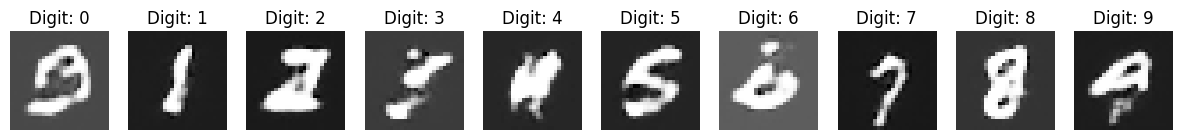

In [148]:
def generate_digits_for_all_classes(generator, noise_dim):
    num_classes = 10
    noise = tf.random.normal([num_classes, noise_dim]) 
    labels = np.eye(num_classes) 
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    generated_images = generator([noise, labels], training=False)

    fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))
    for i in range(num_classes):
        axs[i].imshow(generated_images[i, :, :, 0], cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"Digit: {i}")
    plt.show()

generate_digits_for_all_classes(generator, noise_dim)

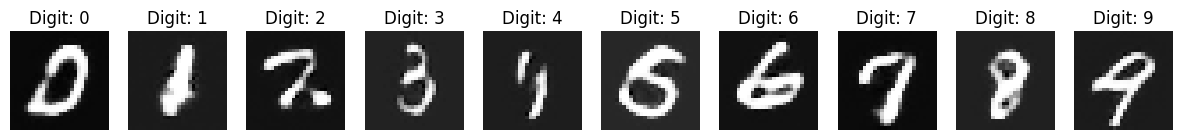

In [165]:
# Po wersji poprawionej
def generate_digits_for_all_classes(generator, noise_dim):
    num_classes = 10
    noise = tf.random.normal([num_classes, noise_dim]) 
    labels = np.eye(num_classes) 
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    generated_images = generator([noise, labels], training=False)

    fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))
    for i in range(num_classes):
        axs[i].imshow(generated_images[i, :, :, 0], cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"Digit: {i}")
    plt.show()

generate_digits_for_all_classes(generator, noise_dim)

Początkowe wyniki generowania cyfr przez model były niezadowalające. Cyfry były rozmyte, o niskim kontraście i czasem trudne do rozpoznania. Szczególnie zauważalne było to w przypadku cyfr takich jak 2, 3 czy 7, które były bardzo słabo widoczne. Model miał ograniczoną zdolność do generowania realistycznych obrazów, co wskazywało na potrzebę poprawy zarówno generatora, jak i dyskryminatora.
Wprowadzone zmiany w architekturze znacząco poprawiły jakość generowanych obrazów. Zwiększono liczbę filtrów i neuronów w obu komponentach modelu. W generatorze zmieniono liczbę filtrów w warstwach na 256 i 512, co pozwoliło uchwycić bardziej złożone cechy obrazów. Dodano również więcej warstw przekształcających (Conv2DTranspose), co umożliwiło lepsze modelowanie obrazu o wysokiej rozdzielczości. W dyskryminatorze wzmocniono warstwy konwolucyjne, zwiększając liczbę filtrów do 128 i 256, co pozwoliło na bardziej szczegółową analizę obrazu. Dodanie dodatkowych warstw Dense i Dropout poprawiło zdolność dyskryminatora do odróżniania rzeczywistych obrazów od generowanych.
Po wprowadzeniu tych zmian wyniki znacznie się poprawiły. Generowane cyfry stały się wyraźniejsze, bardziej szczegółowe i łatwiejsze do rozpoznania. Na przykład cyfry 2, 3, 6 czy 8, które wcześniej były niewyraźne, teraz wyglądają znacznie bardziej realistycznie. Również kontrast między tłem a cyfrą oraz kształty cyfr uległy znacznej poprawie. 
